# Evolutionary SVM Kernel Selection
This is a basic bit of code to implement an evolutionary kernel selection for support vector machines. This is created more as a fun project than as a serious program, and is created without consultation with relevant literature. There is no siginificant performance gain from this method.

## Test Dataset
As a simple sample dataset, the heart failure prediction dataset is used for the time being: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

In [77]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from random import randint, getrandbits, choices

data = pd.read_csv('./heart.csv')
data = pd.get_dummies(data, drop_first = True, dtype = int)
data.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,0,1,0,1,0,1,0,0,0,1


In [78]:
X = data.drop(['HeartDisease'], axis=1)
Y = data['HeartDisease']
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=133)

In [79]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [80]:
# Create a custom polynomial kernel function with modifiable coefficients
def custom_polynomial_kernel(X, Y=None, degree=3, coef_list=None, gamma=None, coef0=1):
    if Y is None:
        Y = X
    n_features = X.shape[1]
    if gamma is None:
        gamma = 1 / n_features
    
    # Compute the linear kernel (dot product)
    K = np.dot(X, Y.T)

    # Apply gamma and coef0 as in the sklearn formula
    K = gamma * K + coef0

    # Polynomial expansion
    if coef_list is None or len(coef_list) < degree + 1:
        coef_list = [1] * (degree + 1)

    K_custom = np.zeros_like(K)
    K_custom += coef_list[0]  # Constant term (d=0)

    for d in range(1, degree + 1):
        K_custom += coef_list[d] * (K ** d)

    return K_custom

## Initializing individuals

In [81]:
num_individuals: int = 40 # Number of individuals in our population
max_degree: int = 4 # Max degree of polynomial kernel
max_coefficient: int = 40 # Max coefficient (+/-) of polynomial.

individuals: list[list[int]] = []

for x in range(num_individuals - 1):
    individuals.append([])
    for y in range(max_degree + 1):
        individuals[x].append([])
        individuals[x][y] = randint(-max_coefficient,max_coefficient)
    print(individuals[x])


[32, -9, 11, 23, -2]
[-21, -36, 33, 0, -7]
[16, 34, -4, -14, -1]
[-31, 19, -32, -3, -9]
[11, -23, -9, -29, 0]
[26, 9, -11, -37, 21]
[-30, -1, 26, -10, -36]
[17, -24, 13, -2, -38]
[-39, 27, 23, 31, 29]
[10, -12, 31, -33, 0]
[4, -8, -39, 16, -14]
[15, 34, -38, -3, 12]
[-1, -30, -12, 24, -34]
[27, -16, -10, -37, 12]
[24, 30, -3, -8, -4]
[17, -31, -32, 16, 8]
[-5, 4, -32, 10, 4]
[35, 18, -18, 20, 38]
[40, -21, -8, 27, -21]
[-17, -7, -15, 39, -21]
[-40, 27, 6, -19, -36]
[19, 16, -32, 34, -4]
[-39, 0, -35, 9, -8]
[-27, -30, -13, 33, 26]
[24, 22, -22, -8, -31]
[-21, -5, 15, 23, 1]
[24, -17, 7, -29, -31]
[-9, -17, 0, -38, -37]
[-32, -10, -13, 40, 28]
[8, -25, -16, 6, -9]
[34, -5, -23, -30, -30]
[2, 25, -1, -25, -21]
[12, 10, -22, -32, -38]
[-35, -37, -37, 17, -20]
[23, -22, -32, 13, -16]
[6, 36, 24, -32, -7]
[-3, -27, 20, -6, -5]
[25, 13, -3, -30, 29]
[-40, 11, 17, -13, 18]


## Evolution Process Definition
To define the fitness, we want a model that runs quickly and that is performative.

In [82]:
from time import process_time

# Calculate the f1score and training time for an individual
def calculate_individual_score(individual:list[int]) -> list[float]:
    model = svm.SVC(kernel = lambda X, Y: custom_polynomial_kernel(X, Y, degree=max_degree, coef_list=individual))
    start = process_time()
    model.fit(X_train,Y_train)
    end = process_time()
    predictions = model.predict(X_test)
    time = end - start
    f1 = float(f1_score(Y_test, predictions))
    return [time,f1]

# Calculate fitness, measured as the likeelihood that the individual should reproduce, for all individuals.
def calculate_fitness(individuals: list[list[int]]) -> list[float]:
    scores: list[list[float]] = []
    fitness: list[float] = []
    f1_max = 0
    f1_min = 1
    best_individual: list[int] = []

    time_total: float = 0
    f1_total: float = 0
    for x in individuals:
        score = calculate_individual_score(x)
        scores.append(score)
        if score[1] > f1_max: 
            f1_max = score[1]
            best_individual = x
        if score[1] < f1_min: f1_min = score[1]

        time_total += score[0]
        f1_total += score[1]**3
    
    for x in scores:
        time_score = x[0]/time_total
        f1_score = (x[1]-f1_min)/f1_total
        fitness.append(0.99 * f1_score + 0.01 * time_score) # Make the overall score 99% from performance, 1% from time
    
    print(f1_max)
    return{"fitness": fitness, "f1max": f1_max, "best_individual": best_individual}

def offspring(mates:list[list[int]]) -> list[int]:
    new_individual = []
    for x in range(max_degree + 1):
        if (randint(0,100) < 5): # 5% chance of mutation to a random new integer
            new_individual.append(randint(0,100))
        elif (getrandbits(1)):
            new_individual.append(mates[0][x])
        else:
            new_individual.append(mates[1][x])
    #print(mates[0], mates[1], new_individual)
    return new_individual
        

def generate_new_population(individuals:list[list[int]]) -> dict[list[list[int]], float]:
    fitness_info = calculate_fitness(individuals)
    fitness = fitness_info["fitness"]
    new_population: list[list[int]] = []
    new_population.append(fitness_info["best_individual"]) # Keep the best performing indvidual from the previous trial.

    for x in range(num_individuals-1): # Add in number of individuals -1 since we are keeping the best performing individual.
        mates: list[list[int]] = []
        if (randint(0,100) < 85): # 75% chance that fitness is important for choosing mates
            mates = choices(individuals, weights=fitness, k=2)
        else:   #25% of random mates to maintain biodiversity
            mates = choices(individuals, k=2)

        new_population.append(offspring(mates))

    #print(new_population)
    return {"population": new_population, "maxf1": fitness_info["f1max"]}


## Evolution Loop

Evolve the population and select the best performing individual.

0.8361204013377926
0
0.839344262295082
1
0.839344262295082
2
0.839344262295082
3
0.839344262295082
4
0.839344262295082
5
0.8469055374592834
6
0.8469055374592834
7
0.8469055374592834
8
0.8469055374592834
9
0.8469055374592834
10
0.8469055374592834
11
0.8469055374592834
12
0.8469055374592834
13
0.8469055374592834
14
0.8469055374592834
15
0.847682119205298
16
0.847682119205298
17
0.847682119205298
18
0.847682119205298
19
0.847682119205298
20
0.847682119205298
21
0.847682119205298
22
0.847682119205298
23
0.847682119205298
24
0.847682119205298
25
0.847682119205298
26
0.847682119205298
27
0.847682119205298
28
0.847682119205298
29
0.847682119205298
30
0.847682119205298
31
0.847682119205298
32
0.847682119205298
33
0.847682119205298
34
0.8514851485148515
35
0.8664495114006515
36
0.8664495114006515
37
0.8664495114006515
38
0.8664495114006515
39
0.8664495114006515
40
0.8664495114006515
41
0.8664495114006515
42
0.8664495114006515
43
0.8664495114006515
44
0.8664495114006515
45
0.8664495114006515
46


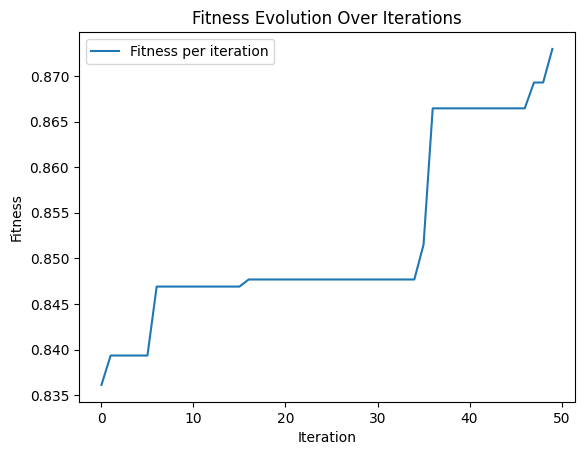

In [83]:
import matplotlib.pyplot as plt
numiter = 50

fitnesses: list[float] = []
for x in range(numiter):
    evolution = generate_new_population(individuals)
    individuals = evolution["population"]
    fitnesses.append(evolution["maxf1"])
    print(x)
    
# Plot the fitness values
plt.plot(range(numiter), fitnesses, label="Fitness per iteration")
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.title("Fitness Evolution Over Iterations")
plt.legend()
plt.show()

In [84]:
scores: list[list[float]] = []
fitness: list[float] = []
f1_max = 0
time_of_max = 0
best_individual: list[int] = []

time_total: float = 0
f1_total: float = 0
for x in individuals:
    score = calculate_individual_score(x)
    if score[1] > f1_max:
        f1_max = score[1]
        best_individual = x
        time_of_max = score[0]

print(best_individual)
print(time_of_max)
print(f1_max)


[76, 87, 71, 6, -4]
0.015782999999998992
0.8729641693811075


## Testing

Comparing the selected individual to the base sklearn 'poly' kernel.

In [85]:
model = svm.SVC(kernel = lambda X, Y: custom_polynomial_kernel(X, Y, degree=max_degree, coef_list=best_individual))
model.fit(X_train,Y_train)
predictions = model.predict(X_test)
print(f'Accuracy is {accuracy_score(Y_test, predictions)}, Precision is {precision_score(Y_test, predictions)}, Recall is {recall_score(Y_test, predictions)}')


baseline = svm.SVC(kernel = 'poly')
baseline.fit(X_train,Y_train)
baseline_predictions = baseline.predict(X_test)
print(f'BASELINE: Accuracy is {accuracy_score(Y_test, baseline_predictions)}, Precision is {precision_score(Y_test, baseline_predictions)}, Recall is {recall_score(Y_test, baseline_predictions)}')

Accuracy is 0.8586956521739131, Precision is 0.8701298701298701, Recall is 0.8758169934640523
BASELINE: Accuracy is 0.855072463768116, Precision is 0.864516129032258, Recall is 0.8758169934640523


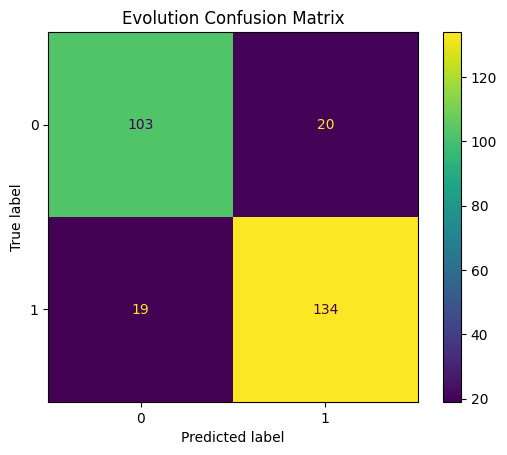

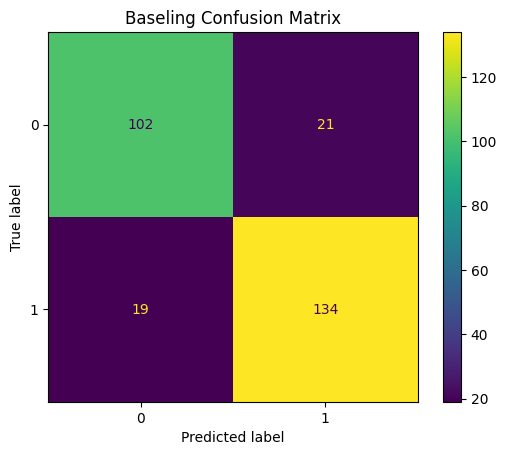

In [88]:
cm1 = confusion_matrix(Y_test, predictions)
cm1_display = ConfusionMatrixDisplay(confusion_matrix = cm1, display_labels = [0, 1])
cm1_display.plot()
plt.title("Evolution Confusion Matrix")
plt.show()

cm2 = confusion_matrix(Y_test, baseline_predictions)
cm2_display = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=[0, 1])
cm2_display.plot()
plt.title("Baseline Confusion Matrix")
plt.show()